In [ ]:
迁移学习：
1、微调Convnet
2、将Convnet看成固定的特征提取器  

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
data_dir = r'hymenoptera_data'
BATCH_SIZE=4

data_transforms = transforms.Compose([
    transforms.Resize(640),#缩放
    transforms.CenterCrop(224),#裁剪
    transforms.ToTensor()#再把图片转换成tensor
    #(3,h,w)
])
image_datasets = {
    p: datasets.ImageFolder(os.path.join(data_dir, p), data_transforms)
       for p in ['train', 'val']
}

dataloaders = {p: torch.utils.data.DataLoader(image_datasets[p], batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=4)
              for p in ['train', 'val']}
dataset_sizes = {p: len(image_datasets[p]) for p in ['train', 'val']}

class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)



{'train': 244, 'val': 153}
['ants', 'bees']


In [55]:
dataset_sizes

{'train': 244, 'val': 153}

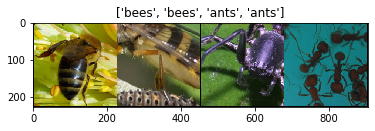

In [4]:
def imshow(image, title=None):
    image = image.numpy().transpose((1,2,0)) #(h,w,3)3个颜色
    plt.imshow(image)
    if title:
        plt.title(title)

images, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(images)#图片拼成一个网格
imshow(out, title=[class_names[label] for label in classes])


In [17]:
NUM_EPOCHES = 5

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, len(class_names))
#因为初始的output_features是1000，我们只有两个类：bees, ants
#所以要重写Linear

model.to(device)

loss_func = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

for ep in range(NUM_EPOCHES):
    print('Epoch %d' % ep, end='\t')
    
    for phase in ['train', 'val']:
        is_training = phase == 'train'
        model.train(is_training)
    
        running_loss, running_corrects = 0, 0
        
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(is_training):
                #在使用的时候是设置一个上下文环境，
                #也就是说只要设置了torch.set_grad_enabled(False)
                #那么接下来所有的tensor运算产生的新的节点都是不可求导的
                #因此不管是train还是val数据集，都进行了前向传播
                #但是在val上因为判断为False,不会求导新节点
                
                outputs = model(inputs) #(b,C)C是类别的数量
                _, preds = torch.max(outputs, 1) 
                #max(outputs, 0)是返回每一列中最大的概率
                #max(outputs, 1)是行
                loss = loss_func(outputs, labels)

            #反向传播
            if is_training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()*inputs.size(0)
            #inputs的第一维是它的batch_size
            running_corrects += torch.sum(preds == labels.data)
        
        ep_loss = running_loss / dataset_sizes['train']
        ep_acc = running_corrects.double() / dataset_sizes['train']
        #running_corrects是整数，需要转成double类型
        print('%s Loss: %.3f, Acc: %.2f' % (phase, ep_loss, ep_acc),
              end='\t' if is_training else None)

Epoch 0	train Loss: 0.621, Acc: 0.69	val Loss: 0.196, Acc: 0.54
Epoch 1	train Loss: 0.496, Acc: 0.76	val Loss: 0.195, Acc: 0.53
Epoch 2	train Loss: 0.538, Acc: 0.77	val Loss: 0.137, Acc: 0.58
Epoch 3	train Loss: 0.382, Acc: 0.81	val Loss: 0.131, Acc: 0.58
Epoch 4	train Loss: 0.499, Acc: 0.76	val Loss: 0.182, Acc: 0.56


In [16]:
model.fc

Linear(in_features=512, out_features=2, bias=True)